# About

We need a good order parameter to distinguish stability.
This notebook is for developing this OP, which is essentially a measure of how far apart the protomer falls.

In [1]:
import signac
import numpy as np
from glotzformats import reader
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import tqdm
import gsd
from gsd import fl
from gsd import hoomd as gsdhoomd
from freud.box import Box
import itertools

%matplotlib notebook

### My analysis
The centroid_msd function computes the distance of the particles from their centroid at each step.
This is my preferred form of analysis.
**Note: I am logging the value directly in HOOMD now, but I may still need to recalculate it on the fly.**

In [2]:
def centroid_MSD(positions, box):
    """Compute the MSD of particles relative to the centroid.
    This method accounts for box periodicity and the minimum image convention
    
    Args:
        positions(np.array): A position array of shape (frames, particles, coordinates)
        box (glotzformats.box): The box"""
    positions = positions.copy()
    box = traj[0].box # Use the first box since they're all identical

    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)
    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)

    # To apply minimum image convention, just choose one of the particles
    # as the basis and find the closest images of everything to that one
    basis_particle = positions[:, np.newaxis, 0, :]
    vectors = positions-basis_particle
    positions[:, :, 0] = np.where(np.abs(vectors[:, :, 0]) > box.Lx/2,
                                box.Lx - np.abs(positions[:, :, 0]),
                                positions[:, :, 0])
    positions[:, :, 1] = np.where(np.abs(vectors[:, :, 1]) > box.Ly/2,
                                box.Ly - np.abs(positions[:, :, 1]),
                                positions[:, :, 1])
    positions[:, :, 2] = np.where(np.abs(vectors[:, :, 2]) > box.Lz/2,
                                box.Lz - np.abs(positions[:, :, 2]),
                                positions[:, :, 2])

    # Now compute the centroids for each step and find deviations
    centroids = np.mean(positions, axis = 1)
    centroids = centroids[:, np.newaxis, :]
    deltas = positions - centroids
    distances = np.linalg.norm(deltas, axis = -1)
    avg_distances = np.mean(distances, axis = -1)
    return avg_distances

In [3]:
def centroid_Rg(positions, box):
    """Compute the radius of gyration of particles relative to the centroid.
    This method accounts for box periodicity and the minimum image convention
    
    Args:
        positions(np.array): A position array of shape (frames, particles, coordinates)
        box (glotzformats.box): The box"""
    positions = positions.copy()
    box = traj[0].box # Use the first box since they're all identical

    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)
    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)

    # To apply minimum image convention, just choose one of the particles
    # as the basis and find the closest images of everything to that one
    basis_particle = positions[:, np.newaxis, 0, :]
    vectors = positions-basis_particle
    positions[:, :, 0] = np.where(np.abs(vectors[:, :, 0]) > box.Lx/2,
                                box.Lx - np.abs(positions[:, :, 0]),
                                positions[:, :, 0])
    positions[:, :, 1] = np.where(np.abs(vectors[:, :, 1]) > box.Ly/2,
                                box.Ly - np.abs(positions[:, :, 1]),
                                positions[:, :, 1])
    positions[:, :, 2] = np.where(np.abs(vectors[:, :, 2]) > box.Lz/2,
                                box.Lz - np.abs(positions[:, :, 2]),
                                positions[:, :, 2])

    # Now compute the centroids for each step and find deviations
    centroids = np.mean(positions, axis = 1)
    centroids = centroids[:, np.newaxis, :]
    deltas = positions - centroids
    distances = np.linalg.norm(deltas, axis = -1)
    
    # Only difference with simple distance calc is that instead of averaging here, we take the norm
    rgs = np.linalg.norm(distances, axis = -1)/np.sqrt(distances.shape[1])
    return rgs

### Unit conversion

While my data space is in terms of kappa, ideally we would want the data space to be in terms of the concentrations.
This function performs the conversion for plotting purposes.

In [4]:
def kappa_to_conc(kappa, eps=None, T=None):
    """Converts kappa (the inverse screening length) into a concentration in millimolar units"""
    e = 1.60217646e-19
    a = 8.864187817e-12
    k = 1.3806485279e-23
    Na = 6.0221415e23
    T_def = 300
    epsr_def = 78 #Note that this term is temperature dependent
    if eps is None:
        eps = epsr_def
    if T is None:
        T = T_def
    return 1000*(a*eps*k*T)/(((kappa * 10**(9))**(-2)) * (e**2) * Na * 2000)
kappa_to_conc(0.73)

49.360780329933135

### Standardized plot

In [14]:
#mpl.rcParams.update(mpl.rcParamsDefault) # To reset to defaults
#plt.rcParams['errorbar.capsize'] = 5.0
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif', serif='Times')
from matplotlib import font_manager
class pretty_error_plot(object):
    def __init__(self, fig=None, ax=None, fs=None, xlabel=None, ylabel=None, title=None,
                 cmap=None, error_fill=False, use_legend=True, ypad=0.05, xpad=0.05, facets=(),
                 rescale_plot=True):
        if fig is None and ax is None:
            if fs is None:
                fs = (8, 6)
            if facets:
                fig, ax = plt.subplots(*facets, figsize=fs)
                plt.subplots_adjust(hspace=0.3, wspace=0.3)
            else:
                fig, ax = plt.subplots(1, 1, figsize=fs)
        self.fig = fig
        self.ax = ax

        # Standardize some plotting standards
        if rescale_plot:
            # Whether or not to enforce 4/3 plot
            dims = fig.get_size_inches()
            if np.abs(dims[0]/dims[1] - 4/3) > 0.1:
                fig.set_size_inches(dims[1]*4/3, dims[1])
        if facets:
            for a in ax.flatten():
                a.spines["top"].set_visible(False)  
                a.spines["right"].set_visible(False)  
        else:
            ax.spines["top"].set_visible(False)  
            ax.spines["right"].set_visible(False)  

        # Labeling
        ticks_font = font_manager.FontProperties(
            family='Arial', style='normal', weight='normal', stretch='normal', size=16)
        if facets:
            for a in ax.flatten():
                a.tick_params(axis='both', which='major', labelsize=30)
                a.tick_params(axis='both', which='minor', labelsize=16)
                for label in a.get_xticklabels():
                    label.set_fontproperties(ticks_font)
                for label in a.get_yticklabels():
                    label.set_fontproperties(ticks_font)
        else:
            ax.tick_params(axis='both', which='major', labelsize=30)
            ax.tick_params(axis='both', which='minor', labelsize=16)
            for label in ax.get_xticklabels():
                label.set_fontproperties(ticks_font)
            for label in ax.get_yticklabels():
                label.set_fontproperties(ticks_font)

        if title:
            self.title = title
            if facets:
                fig.suptitle(title, fontsize=24)
            else:
                ax.set_title(title, fontsize=24)  
        if xlabel:
            self.xlabel = xlabel
            if facets:
                # Only label the edges
                for i, ax_row in enumerate(ax):
                    for j, a in enumerate(ax_row):
                        if i == facets[0]-1:
                            a.set_xlabel(xlabel, fontsize=20)  
            else:
                ax.set_xlabel(xlabel, fontsize=20)  
        if ylabel:
            self.ylabel = ylabel
            if facets:
                for i, ax_row in enumerate(ax):
                    for j, a in enumerate(ax_row):
                        if j == 0:
                            a.set_ylabel(ylabel, fontsize=20)  
            else:
                ax.set_ylabel(ylabel, fontsize=20)  
        
        self.num_plots = 0
        if cmap:
            self.cmap = plt.get_cmap(cmap)
        else:
            self.cmap = None
        self.use_legend = use_legend
        self.xpad = xpad
        self.ypad = ypad
        self.error_fill = error_fill
        self.lines = [] 
        self.ebarcaps = []
        self.ebars = []
        self.xdata = [] 
        self.ydata = [] 
        if facets:
            self.tot_plots = facets[0]*facets[1]
        else:
            self.tot_plots = 1
        self.facets = facets
        
        # Establish sensible limits
        self.xmin = np.inf
        self.xmax = -np.inf
        self.ymin = np.inf
        self.ymax = -np.inf
        
            
    def add_plot(self, x, y, yerr=None, plot_title=None, *args, **kwargs):
        if self.facets:
            if self.facets[0] == 1 or self.facets[1] == 1:
                # If it's a 1d array
                ax = self.ax[self.num_plots]
            else:
                xpos = self.num_plots // self.facets[1]
                ypos = self.num_plots % self.facets[1]
                ax = self.ax[xpos, ypos]
        else:
            ax = self.ax
        if yerr is not None:
            if self.error_fill:
                lines = ax.scatter(x, y, *args, **kwargs)
                self.lines.append(lines[0])
                self.ebars.append(ax.fill_between(x, y-yerr, y+yerr))
            else:
                [plotline, caplines, barlinecols] = ax.errorbar(x, y, yerr, *args, **kwargs)
                self.lines.append(plotline)
                self.ebarcaps.append(caplines)
                self.ebars.append(barlinecols)
        else:
            lines = ax.scatter(x, y, *args, **kwargs)
            self.lines.append(lines[0])
        
        if plot_title is not None:
            ax.set_title(plot_title, fontsize=20)
        
        # Update limits
        curxmin = np.nanmin(x)
        curxmax = np.nanmax(x)
        if curxmin < self.xmin:
            self.xmin = curxmin
        if curxmax > self.xmax:
            self.xmax = curxmax
            
        if yerr is not None:
            curymin = np.nanmin(y-yerr)
            curymax = np.nanmax(y+yerr)
        else:
            curymin = np.nanmin(y)
            curymax = np.nanmax(y)
            
        if curymin < self.ymin:
            self.ymin = curymin
        if curymax > self.ymax:
            self.ymax = curymax
            
        self.num_plots += 1
        
    def disp(self, scale=True):
        # Figure out how many colors are needed, then set
#        if self.cmap is not None:
#            color_nums = np.linspace(0, 0.9, self.num_plots)
#            colors = [self.cmap(c) for c in color_nums]
#        
#            for i, plotline in enumerate(self.lines):
#                plotline.set_color(colors[i])
#                if len(self.ebars):
#                    if self.error_fill:
#                        self.ebars[i].set_color(colors[i])
#                    else:
#                        for eb in self.ebars[i]:
#                            eb.set_color(colors[i])
#                        for ebc in self.ebarcaps[i]:
#                            ebc.set_color(colors[i])
            
        # Fix limits
        if scale:
            xpad = (self.xmax-self.xmin)*self.xpad
            self.xmax += xpad
            self.xmin -= xpad

            ypad = (self.ymax-self.ymin)*self.ypad
            self.ymax += ypad
            self.ymin -= ypad
            
            if self.facets:
                for a in self.ax.flatten():
                    a.set_xlim(left=self.xmin, right=self.xmax)
                    a.set_ylim(bottom=self.ymin, top=self.ymax)
            else:
                self.ax.set_xlim(left=self.xmin, right=self.xmax)
                self.ax.set_ylim(bottom=self.ymin, top=self.ymax)
            
        if self.use_legend:
            if self.facets:
                if len(self.ebars):
                    for a in self.ax.flatten():
                        handles, labels = a.get_legend_handles_labels()
                        handles = [h[0] for h in handles]
                        a.legend(handles, labels, loc='best', fontsize=20)
                else:
                    for a in self.ax.flatten():
                        a.legend(loc='best', fontsize=20)
            else:
                if len(self.ebars):
                    handles, labels = self.ax.get_legend_handles_labels()
                    handles = [h[0] for h in handles]
                    self.ax.legend(handles, labels, loc='best', fontsize=20)
                else:
                    self.ax.legend(loc='best', fontsize=20)
            
        # Show
        self.fig.canvas.draw()

### Accumulate Data

In [6]:
project = signac.get_project()
r = reader.GSDHoomdFileReader()
fn = 'evaluate.gsd'
data_fn = 'evaluate_centroid.log'

jobs = []
kappas = []
run_nums = []
distances = []
rgs = []
initial_rgs = []
num_frames = []
pdb_files = []

# Whether to use the dump file or recalculate distances on the fly 
recalc_distance = True
job_cursor = project.find_jobs(
                 {"$or":
                        [
                            {"refined": True},
                            {"$and":
                                    [
                                        {"pdb_file": 'protomer_1_alternating_head_tail.pdb'},
                                        {"shift": {"$exists": False}}
                                    ]
 
                            }
                        ]
                 })
for job in tqdm.tqdm_notebook(job_cursor):
    if job.isfile(data_fn):
        with job:
            if recalc_distance:
                with open(job.fn(fn), 'rb') as f:
                    try:
                        traj = r.read(f)
                        traj.load_arrays()

                        # Find the first frame after compression
                        first_step = 1 + job.doc.num_expansions_evaluate + job.doc.evaluate_num_steps_compressed
                        gsd_traj = gsd.hoomd.open(job.fn('evaluate.gsd'))
                        initial_rgs.append(centroid_Rg(traj.positions[:1], traj[0].box)[0])
                        for i, frame in enumerate(gsd_traj):
                            if frame.configuration.step > first_step:
                                break
                        distances.append(centroid_MSD(traj.positions[i:], traj[i].box))
                        rgs.append(centroid_Rg(traj.positions[i:], traj[i].box))
                    except Exception as e:
                        # Some of the GSDs are corrupted for some reason
                        print("Allowing exception {} through".format(e))
                        continue
            else:
                try:
                    tmp = np.genfromtxt(data_fn, invalid_raise=False)[:, -1]
                    distances.append(tmp)
                except:
                    print("Failed for job {}".format(job))
                    continue
                
        # Can't store the segments directly since they're a list
        # (pandas allows, but grouping fails), so instead store
        # an id with a lookup table
        jobs.append(job)
        kappas.append(job.sp.kappa)
        run_nums.append(job.sp.run_num)
        pdb_files.append(job.sp.get('pdb_file', 'refined.pdb'))

In [7]:
# Don't require storing distances since they may not all be necessary
interval = 100 # The number of samples used in the actual run for termination
initial_rg = np.mean(initial_rgs)
df_data_all = pd.DataFrame(dict(
    job = jobs,
    jobid = [j.get_id() for j in jobs],
    kappa = kappas,
    distance = distances,
    rg = rgs,
    run_num = run_nums,
    avg_distance = [np.mean(x) for x in distances],
    avg_rg = [np.mean(x) for x in rgs],
))
df_data_all['pdb_file'] = df_data_all.apply(lambda row: row['job'].sp.get('pdb_file', 'refined.pdb'), axis=1)

# Remove data points that only have one value and data points where Stampede failed to run the simulation.
counts = df_data_all.groupby(['pdb_file', 'kappa']).count()
to_keep = counts[counts['run_num'] > 1].reset_index()[['kappa', 'pdb_file']]
df_data_final = df_data_all.merge(to_keep, 'inner', on=['kappa', 'pdb_file'])
df_data_final = df_data_final[~((df_data_final['run_num'] > 4) & 
                (df_data_final['pdb_file'] == 'protomer_1_alternating_head_tail.pdb')) &
                             ~((df_data_final['pdb_file'] == 'protomer_1_alternating_head_tail.pdb') &
                              (df_data_final['run_num'] > 3) &
                              (df_data_final['kappa'] > 0.69))]

df_data_final.drop(['distance', 'rg'], axis = 1, inplace = True)
grouped = df_data_final.groupby(['pdb_file', 'kappa'])
def std_mean(x):
    """Helper function to compute the average standard deviation by averaging variances"""
    return np.sqrt(np.sum(np.square(x)))
df_data = grouped.agg(dict(
    avg_distance=['mean', 'std'],
    avg_rg=['mean', 'std'],
    )).reset_index()
df_data.columns = [' '.join(col).strip().replace(' ', '_') for col in df_data.columns.values]
df_data['conc'] = kappa_to_conc(df_data['kappa'])

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


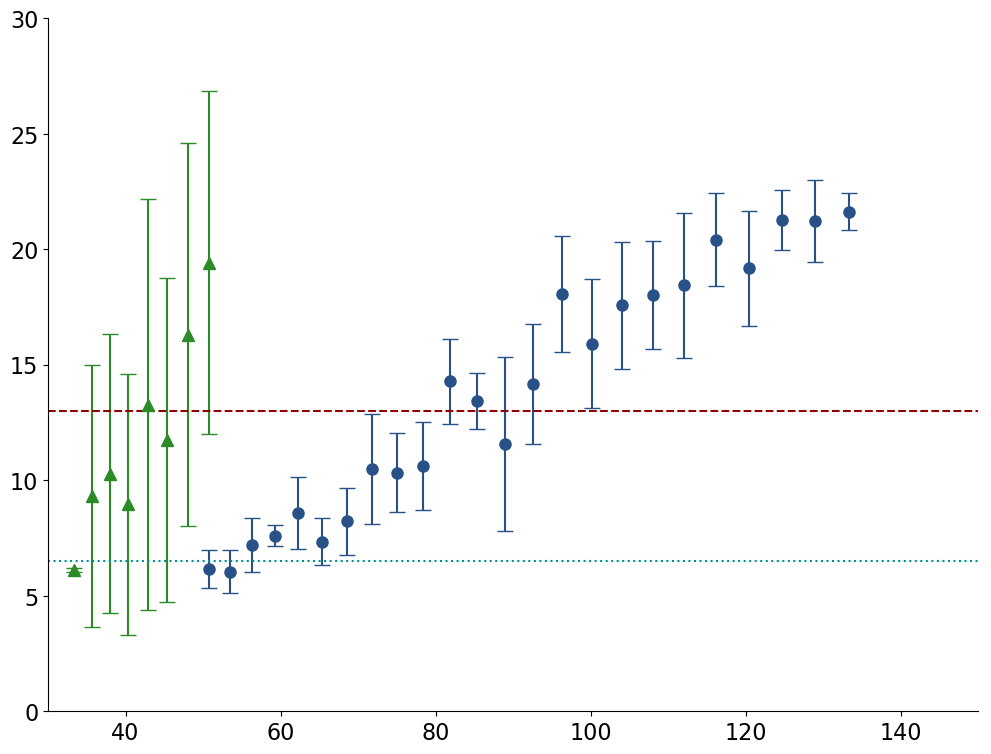

In [18]:
p = pretty_error_plot(#xlabel="Concentration (mM)", ylabel="Distance (nm)", #title="Average distance from centroid",
                      fs=(12, 9), use_legend=False, rescale_plot=False)
for pdb_file in df_data['pdb_file'].unique():
    data_plot = df_data.loc[df_data['pdb_file'] == pdb_file]
    p.add_plot(x=data_plot['conc'], y=np.array(data_plot['avg_rg_mean']), yerr=np.array(data_plot['avg_rg_std']),
               linestyle='None', markersize=8, capsize=6,
               marker='o' if pdb_file == 'refined.pdb' else '^',
               color='#285287' if pdb_file == 'refined.pdb' else '#2B8B27',
               label="Cryo-EM Structure" if pdb_file == 'refined.pdb' else "Negative EM Structure")
p.disp(True)
p.ax.set_ylim([0, 30])
p.ax.set_xlim([30, 150])
#p.ax.set_xlim([0.5, 1.4])
#p.ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle=':', label='intact', c=(0/255, 146/255, 146/255))
#p.ax.axhline(y = 13, xmin=0, xmax=1, linestyle='--', label='denatured', c=(146/255, 0/255, 0/255))
p.ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle=':', c=(0/255, 146/255, 146/255))
p.ax.axhline(y = 13, xmin=0, xmax=1, linestyle='--', c=(146/255, 0/255, 0/255))
#plot.tick_params(axis='both', which='minor', labelsize=8)
#p.fig.legend(prop={'size': 30})
#p.fig.legend(prop={'size': 30, 'family': 'sans-serif'})
p.fig.savefig("images/refined_comparison.eps", format='eps')

In [29]:
tmp = plt.rcParams['font.sans-serif']

In [32]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

In [9]:
df_data.loc[df_data['pdb_file'] == 'refined.pdb'].sort_values(['kappa'])

pdb_file  kappa  avg_distance_mean  avg_distance_std  avg_rg_mean  \
8   refined.pdb   0.74           6.061852          0.787066     6.150058   
9   refined.pdb   0.76           5.914678          0.816330     6.040803   
10  refined.pdb   0.78           6.926130          1.224431     7.185461   
11  refined.pdb   0.80           7.273217          0.440715     7.599450   
12  refined.pdb   0.82           8.019178          1.160165     8.580352   
13  refined.pdb   0.84           7.055677          1.014102     7.331936   
14  refined.pdb   0.86           7.535357          1.554789     8.215531   
15  refined.pdb   0.88           9.907797          2.152916    10.487802   
16  refined.pdb   0.90           9.678976          1.344546    10.335982   
17  refined.pdb   0.92           9.962716          1.794616    10.607351   
18  refined.pdb   0.94          13.287355          1.927165    14.286071   
19  refined.pdb   0.96          12.485757          1.195304    13.436004   
20  refined.pdb   0.98          10.548357          3.831748    11.584667   
21  refined.pdb   1.00          13.013106          2.782249    14.176518   
22  refined.pdb   1.02          16.871727          2.427282    18.058635   
23  refined.pdb   1.04          14.776196          2.738684    15.906469   
24  refined.pdb   1.06          16.385181          2.695287    17.566983   
25  refined.pdb   1.08          16.779337          2.372444    18.007048   
26  refined.pdb   1.10          17.285879          2.986329    18.434898   
27  refined.pdb   1.12          19.184568          1.916505    20.422278   
28  refined.pdb   1.14          17.998114          2.405633    19.172479   
29  refined.pdb   1.16          19.902522          1.297643    21.271300   
30  refined.pdb   1.18          19.937855          1.734483    21.220881   
31  refined.pdb   1.20          20.253712          0.876340    21.625372   

    avg_rg_std        conc  
8     0.833617   50.722393  
9     0.927714   53.501195  
10    1.168244   56.354098  
11    0.447656   59.281102  
12    1.564672   62.282208  
13    1.014100   65.357415  
14    1.468279   68.506724  
15    2.378801   71.730134  
16    1.692131   75.027645  
17    1.903117   78.399258  
18    1.828587   81.844972  
19    1.229663   85.364787  
20    3.770984   88.958704  
21    2.608048   92.626722  
22    2.511606   96.368842  
23    2.786217  100.185063  
24    2.756868  104.075385  
25    2.341142  108.039809  
26    3.145693  112.078334  
27    2.009452  116.190960  
28    2.477188  120.377688  
29    1.299740  124.638518  
30    1.775726  128.973448  
31    0.798140  133.382480